In [ ]:
from datetime import datetime
import numpy as np
import math
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [ ]:
#load the dataset
dataset = pd.read_csv('AAPL.csv', index_col = 0) 
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1+ KB


In [ ]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


#Data preprocessing

In [ ]:
#1. Kiểm tra NaN --> không có NaN
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
#2. Loại bỏ những dòng bị trùng (all-columns, nếu có):
dataset = dataset.drop_duplicates()
dataset = dataset.reset_index(drop=True) 

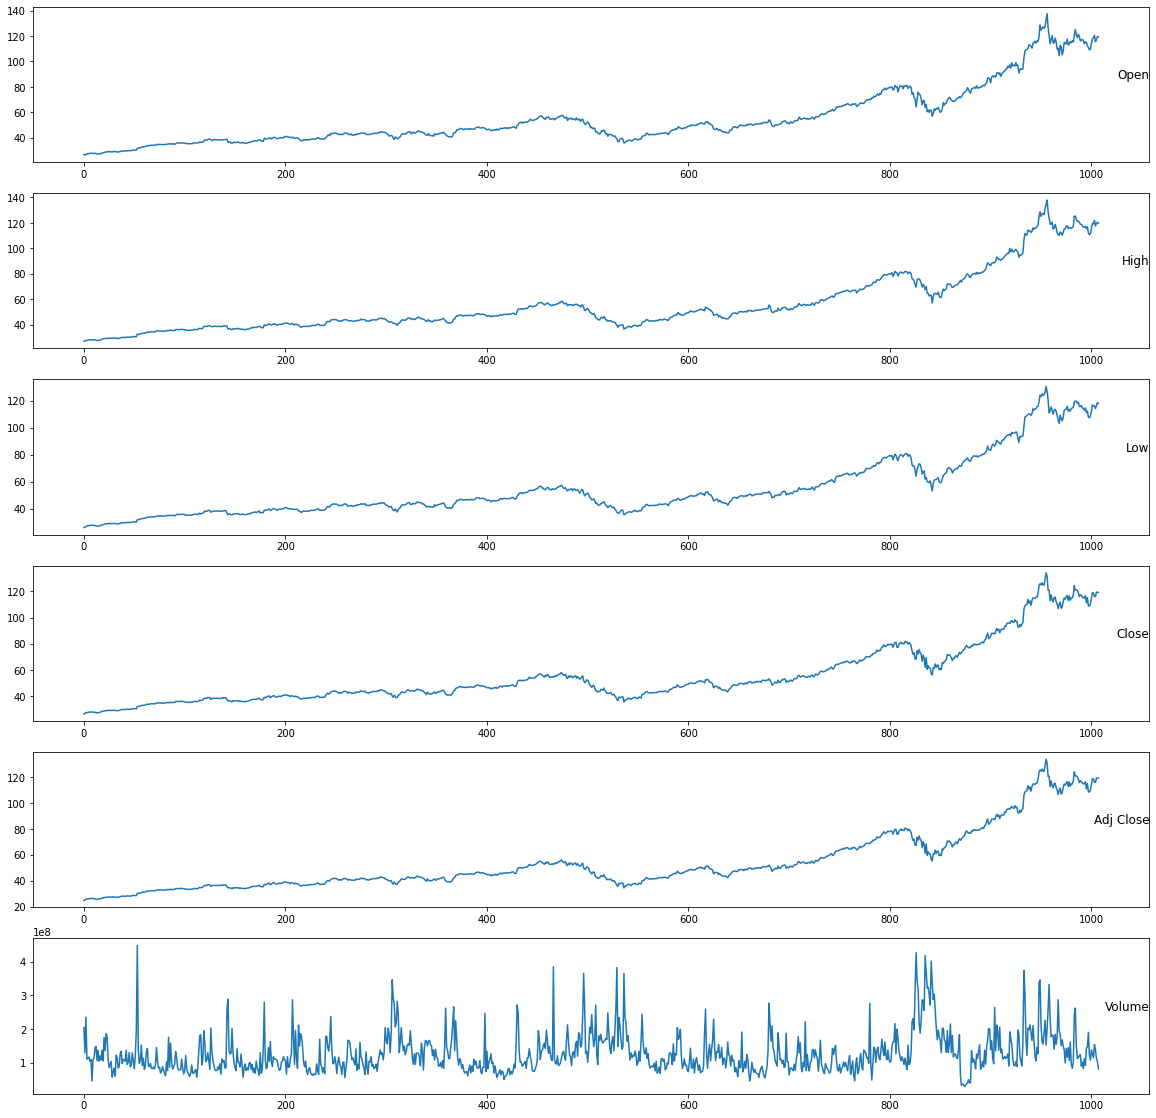

In [ ]:
values = dataset.values
#vẽ các cột ra xem thử quy luật
groups = [0, 1, 2, 3, 4, 5] 
i = 1 
#plot each column
plt.figure(figsize=(20, 20))
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title(dataset.columns[group], y=0.5, loc='right')
  i+=1

plt.show() 

Nhận xét: các cột Open, High, Low, Close, Adj Close có hình dạng tương đối giống nhau, đều tăng dần qua thời gian. Cột Volume có những lúc tăng đột biến trùng với đỉnh của các cột còn lại (khối lượng giao dịch tăng mạnh --> giá đóng của, cao, thấp, điều chỉnh cũng tăng đột biến tại các đỉnh)

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))        
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
	return agg

In [ ]:
# # load dataset
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
print("Frame as Series:")
print(scaled[:5])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print("Frame as supervised learning:")
print(reframed.head())
# Vì chỉ predict thông tin var1(t), còn từ var2(t) trở đi không dự đoán nên drop
# giữ lại các cột từ 0-5 (6 cột đầu là inputs, cột cuối là output)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7, 8, 9, 10, 11]], axis=1, inplace=True)
print("Frame will use:")
print(reframed.head())

Frame as Series:
[[2.5687814e-03 2.9262900e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.1966838e-01]
 [0.0000000e+00 0.0000000e+00 4.9756020e-03 3.2481849e-03 3.0130148e-03
  2.3919241e-01]
 [2.9292703e-04 5.7401359e-03 6.0281307e-03 9.9301785e-03 9.2111528e-03
  4.9281877e-01]
 [7.3007494e-03 6.0102493e-03 1.1362538e-02 9.8373443e-03 9.1250390e-03
  1.9498245e-01]
 [7.0979595e-03 6.4379573e-03 1.3347998e-02 1.0092571e-02 9.3617886e-03
  2.0258759e-01]]
Frame as supervised learning:
   var1(t-1)  var2(t-1)  var3(t-1)  ...   var4(t)   var5(t)   var6(t)
1   0.002569   0.000293   0.000000  ...  0.003248  0.003013  0.239192
2   0.000000   0.000000   0.004976  ...  0.009930  0.009211  0.492819
3   0.000293   0.005740   0.006028  ...  0.009837  0.009125  0.194982
4   0.007301   0.006010   0.011363  ...  0.010093  0.009362  0.202588
5   0.007098   0.006438   0.013348  ...  0.013967  0.012956  0.210563

[5 rows x 12 columns]
Frame will use:
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  v

In [ ]:
len(dataset)

1008

In [ ]:
# split into train and test sets
values = reframed.values
n_train_day = 365  * 2 
train = values[:n_train_day, :]
# còn lại thì là test
test = values[n_train_day:, :]
# split into input and outputs (các cột đầu, cột cuối)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print("Before reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("After reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Before reshape:
(730, 6) (730,) (277, 6) (277,)
After reshape:
(730, 1, 6) (730,) (277, 1, 6) (277,)


In [ ]:
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [ ]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1 sample has 6 feature
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y,
epochs=50,
batch_size=72,
validation_data=(test_X, test_y),
verbose=2
)

Epoch 1/50
11/11 - 3s - loss: 0.1243 - val_loss: 0.4345 - 3s/epoch - 291ms/step
Epoch 2/50
11/11 - 0s - loss: 0.0717 - val_loss: 0.3187 - 59ms/epoch - 5ms/step
Epoch 3/50
11/11 - 0s - loss: 0.0411 - val_loss: 0.2250 - 61ms/epoch - 6ms/step
Epoch 4/50
11/11 - 0s - loss: 0.0403 - val_loss: 0.1967 - 75ms/epoch - 7ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0352 - val_loss: 0.2102 - 64ms/epoch - 6ms/step
Epoch 6/50
11/11 - 0s - loss: 0.0316 - val_loss: 0.1931 - 66ms/epoch - 6ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0272 - val_loss: 0.1435 - 56ms/epoch - 5ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0230 - val_loss: 0.1167 - 74ms/epoch - 7ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0184 - val_loss: 0.0768 - 57ms/epoch - 5ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0135 - val_loss: 0.0398 - 67ms/epoch - 6ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0087 - val_loss: 0.0195 - 69ms/epoch - 6ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0050 - val_loss: 0.0458 - 64ms/epoch - 6ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0036

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


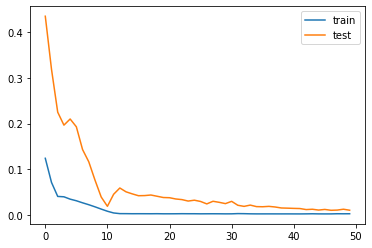

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Nhận xét: đến lần lặp 50 thì loss của train và test gần như bằng nhau

In [ ]:
test_X.shape

(277, 1, 6)

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 1, 6) (730,) (277, 1, 6) (277,)


In [ ]:
def invert_scaling(y, X, s):
    # invert scaling for forecast
    inv_y = np.concatenate((y, X[:, 1:]), axis=1)
    print(s, "shape:", inv_y.shape)
    inv_y = scaler.inverse_transform(inv_y)
    print(s, inv_y.shape)
    # trả lại hình dạng ban đầu
    inv_y = inv_y[:,0]
    return inv_y

In [ ]:
# make a prediction
yhat = model.predict(test_X)
print("Test_x_shape:", test_X.shape)
test_X_now = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print("Test_x_now_shape:", test_X_now.shape)

Test_x_shape: (277, 1, 6)
Test_x_now_shape: (277, 6)


In [ ]:
# # invert scaling for forecast
inv_yhat = invert_scaling(yhat, test_X_now, "inv_yhat")
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = invert_scaling(test_y, test_X_now, "inv_y")

inv_yhat shape: (277, 6)
inv_yhat (277, 6)
inv_y shape: (277, 6)
inv_y (277, 6)


In [ ]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.854
Test MAE: 1.216


Nhận xét: mean của Open ~ 55, MAE của test ~ 1.2 --> model có thể dự đoán Open với sự sai khác so với mean là 1.2/55 ~ 2.2% --> model có thể dùng tốt trong dự đoán

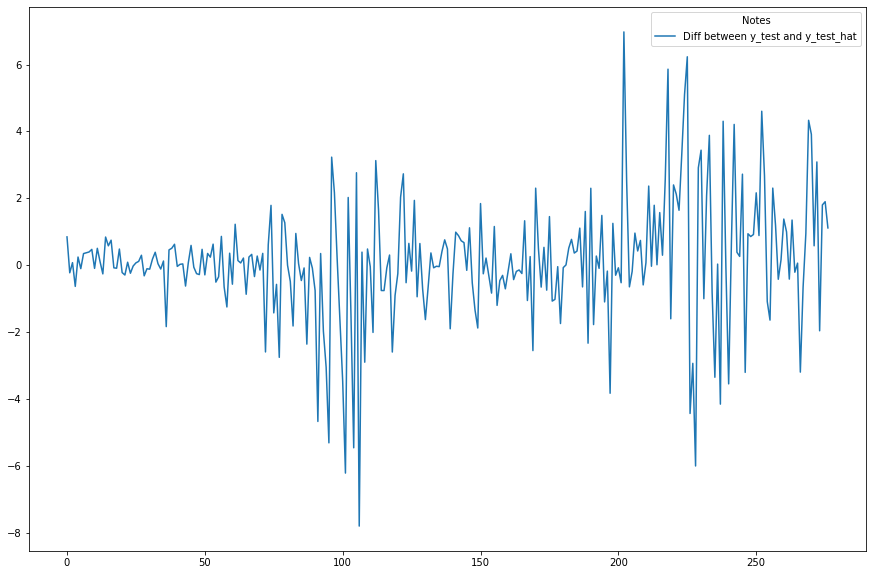

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(inv_y - inv_yhat, label='Diff between y_test and y_test_hat')
plt.legend(title="Notes")
plt.show()

Nhận xét: sai khác giữa real và predict có đột biến ở một số vị trí

In [ ]:
# make a prediction of y
y_train_hat = model.predict(train_X)
train_X_now = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_y_train_hat = invert_scaling(y_train_hat, train_X_now, "inv_y_train_hat")

inv_y_train_hat shape: (730, 6)
inv_y_train_hat (730, 6)


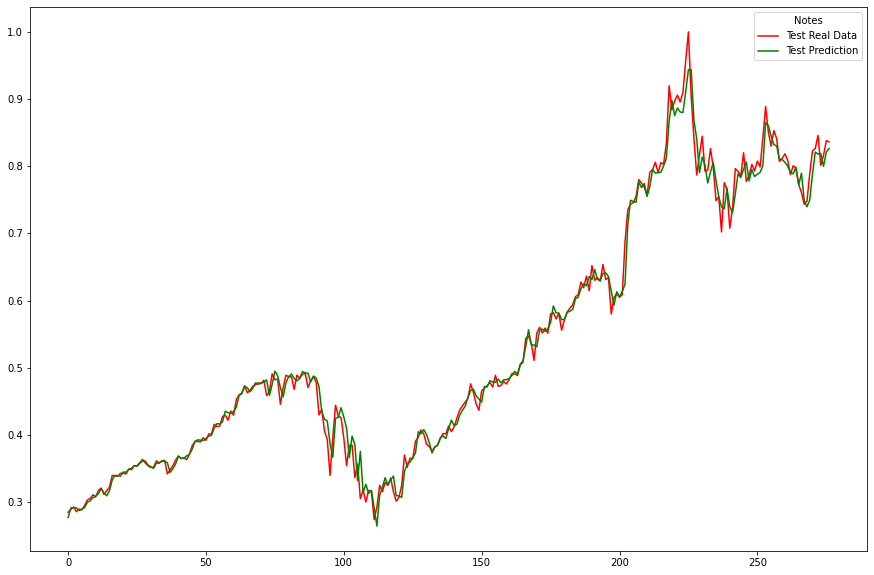

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.plot(test_y, label='Test Real Data', color='red')
plt.plot(yhat, label='Test Prediction', color='green')
plt.legend(title="Notes")
plt.show()

Nhận xét: test bám khá sát so với real data. Tuy nhiên ở một số đỉnh/ đáy thì model dự đoán chưa hoàn toàn chính xác, nhưng phần lớn là khớp --> model phù hợp để dự đoán Open

In [ ]:
print('Val_loss train')
model.evaluate(train_X, train_y)

Val_loss train
23/23 [==============================] - 0s 2ms/step - loss: 0.0031


0.0030641043558716774

In [ ]:
print('Val_loss test')
model.evaluate(test_X, test_y)

Val_loss test
9/9 [==============================] - 1s 3ms/step - loss: 0.0110


0.010964223183691502

Nhận xét: 
* Dựa vào các phân tích trên, model phù hợp để sự dụng vào dự đoán Open.
* So với dùng 1 input (Open) để dự đoán Open, mô hình sử dụng tất cả các cột để dự đoán Open cho kết quả tốt hơn (one-to-one: MAE/mean ~ 13%, many-to-one: MAE/mean ~ 2%)